In [1]:
import numpy as np
import matplotlib.pyplot as plt

V_LS = 21.0 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

#These two terms are added here to be saved for later
orb_ang_momentum = 0
V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.

CENTRAL_POTENTIAL_PARAMETERS = [0.1, 0.151991, 0.231013, 0.351119, 0.53367, 0.811131, 1.23285,
                                1.87382, 2.84804, 4.32876, 6.57933, 10.]

CENTRAL_MIXING_COEFFICIENTS = [0.0558247,0.214443,2.42773,-0.724055,-2.17761,1.02031,0.819031,-0.96538,0.197094,0.3221,-0.296652,0.093208]

SPIN_ORBIT_POTENTIAL_PARAMETERS = [4.16493, 2.843, 1.941, 1.325, 0.905, 0.618, 0.422, 0.288, 0.196, 0.134, 0.0916, 0.0625]

SPIN_ORBIT_MIXING_COEFFICIENTS = [0.273, -1.307, 3.305, -5.657, 6.565, -3.368, -2.437, 2.638, 0.719, 0.235, 0.0186, 0.00108]

In [16]:
def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    normalisation = (2**(-2.5 - orb_ang_momentum) * (range_parameter)**(3 + 2 * orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : array like, the radius to evaluate the potential at
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    array like , potential evaluated at r
    """
    return c * np.exp(-β * (r)**2)

def single_gaussian_potential_gradient(r, c, β):
    return c * (-2 * β) * np.exp(-β * (r)**2)

def gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_function(radius, central_mixing_coefficients[i], central_potential_parameters[i])
    return V_0 * potential

def gaussian_expanded_potential_gradient(radius, orb_ang_momentum, mixing_coefficients, potential_parameters):
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_derivative(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential

def spin_orbit_term(tot_ang_momentum, orb_ang_momentum): # Do we need hbar?
    return 0.5 * (tot_ang_momentum * (tot_ang_momentum + 1) - orb_ang_momentum * (orb_ang_momentum + 1) - 0.75)

def complete_gaussian_potential(radius, tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters,
                                spin_orbit_mixing_coefficients, spin_orbit_potential_parameters, vls=V_LS):
    return gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters
                                      ) - vls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * gaussian_expanded_potential_gradient(
        radius, orb_ang_momentum, spin_orbit_mixing_coefficients, spin_orbit_potential_parameters)
     
def centeral_woods_saxon_potential(radius, tot_ang_momentum, orb_ang_momentum, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    R_0 = r_0 * num_core_nucleons**(1/3)

    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    return central_potential_term

def spin_orbit_potential_without_spin_orbit_coupling(radius, tot_ang_momentum, orb_ang_momentum, V_ls=V_LS,
                                                     diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    R_0 = r_0 * num_core_nucleons**(1/3)
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)
    return - V_ls * woods_saxon_derivative

def complete_woods_saxon_potential(radius, tot_ang_momentum, orb_ang_momentum, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    R_0 = r_0 * num_core_nucleons**(1/3)

    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)

    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * woods_saxon_derivative

C:\Users\faola\AppData\Local\Temp\ipykernel_16092\4031656233.py:58: RuntimeWarning: divide by zero encountered in divide
  woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
C:\Users\faola\AppData\Local\Temp\ipykernel_16092\4031656233.py:68: RuntimeWarning: divide by zero encountered in divide
  woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (


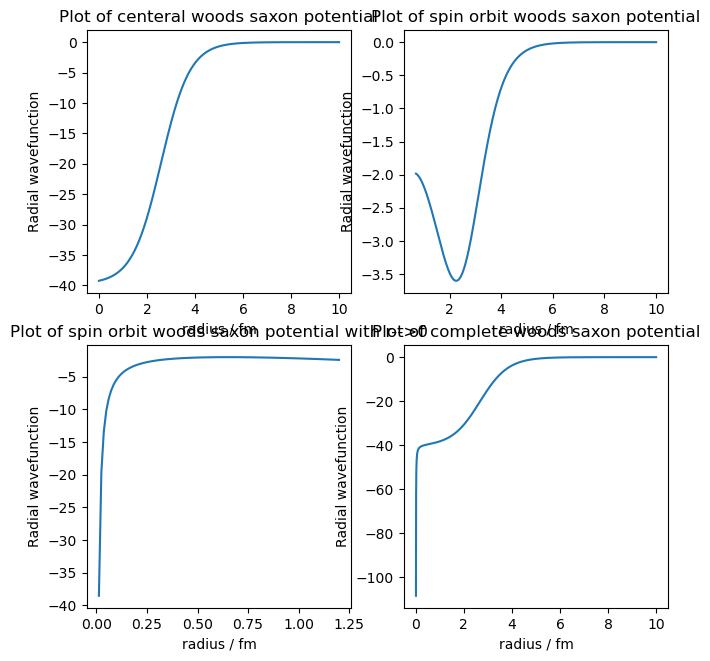

In [22]:
fig = plt.figure(figsize=(7.5,7.5))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

x_values = np.linspace(0., 10, 3000)
x_values_2 = np.linspace(0.7, 10, 3000)
x_values_3 = np.linspace(0, 1.2, 100)

ax_1.set_title(f'Plot of centeral woods saxon potential')
ax_1.set_xlabel('radius / fm')
ax_1.set_ylabel('Radial wavefunction')
ax_1.plot(x_values, centeral_woods_saxon_potential(x_values, 1.5, 1))

ax_2.set_title(f'Plot of spin orbit woods saxon potential')
ax_2.set_xlabel('radius / fm')
ax_2.set_ylabel('Radial wavefunction')
ax_2.plot(x_values_2, spin_orbit_potential_without_spin_orbit_coupling(x_values_2, 1.5, 1))

ax_3.set_title(f'Plot of spin orbit woods saxon potential with r-->0')
ax_3.set_xlabel('radius / fm')
ax_3.set_ylabel('Radial wavefunction')
ax_3.plot(x_values_3, spin_orbit_potential_without_spin_orbit_coupling(x_values_3, 1.5, 1))

ax_4.set_title(f'Plot of complete woods saxon potential')
ax_4.set_xlabel('radius / fm')
ax_4.set_ylabel('Radial wavefunction')
ax_4.plot(x_values, complete_woods_saxon_potential(x_values, 1.5, 1))
